# Ensembles

A classic way of obtaining uncertainty quantification in regression tasks is ensembles – where we quantify uncertainty by looking at the distribution over outputs from an ensemble of emulators.

In AutoEmulate, we try to be as flexible as possible and allow for any combination of emulators with different outputs. To do so, we assume, without loss of generality, that each emulator in the ensemble returns a Gaussian-like output
$$
\mu_i \in \mathbb{R}^d, \quad \Sigma_i \in \mathbb{R}^{d \times d}
$$
where if the emulator is determinstic we simply have $\Sigma_i = 0$.

With this, we can compute an ensemble mean and covariance
$$
\mu_{\mathrm{ens}}
= \frac{1}{M}
  \sum_{i=1}^{M}
    \mu_i,
$$
$$
\Sigma_{\mathrm{ens}}
= \frac{1}{M}
  \sum_{i=1}^{M}
    \Sigma_i
+
  \frac{1}{M - 1}
  \sum_{i=1}^{M}
    \bigl(\mu_i - \mu_{\mathrm{ens}}\bigr)
    \bigl(\mu_i - \mu_{\mathrm{ens}}\bigr)^{T}.
$$

We can then make an ensemble with, e.g., a set of deterministic NNs, a mixed set of NNs and GPs, only GPs, or even a set of Emulators – anything that abides the the Gaussian return type above.

In [1]:
import torch, matplotlib.pyplot as plt
from autoemulate.experimental.emulators.nn.mlp import MLP 
from autoemulate.experimental.emulators.ensemble import Ensemble
%load_ext autoreload
%autoreload 2

Let's start with some simple 1D data
$$
x \in \mathbb{R}^1, \quad y = \sin(x) \in \mathbb{R}^1
$$

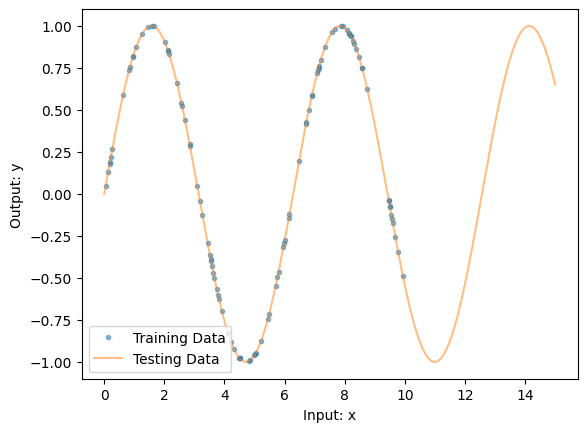

In [3]:
# Training
x_train = torch.rand(100, 1) * 10
x_train = x_train[x_train.flatten().argsort(), :]
y_train = torch.sin(x_train)
plt.plot(x_train.flatten(), y_train.flatten(), '.', label='Training Data', alpha=0.5)

# Testing
x_test = torch.linspace(0.0, 15.0, steps=1000).reshape(-1, 1)
y_test = torch.sin(x_test)
plt.plot(x_test.flatten(), y_test.flatten(), '-', label='Testing Data', alpha=0.5)

# Plot
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.legend()
plt.show()

Let's make a simple deterministic MLP emulator.

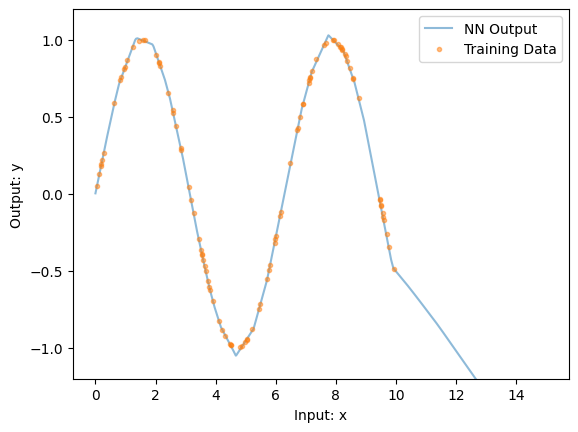

In [4]:
emulator = MLP(x_train, y_train, layer_dims=[100, 100], lr=1e-2)
emulator.epochs = 1000
emulator.fit(x_train, y_train)
y_test_hat = emulator.predict(x_test)
plt.plot(x_test.flatten(), y_test_hat.flatten(), alpha=0.5, label='NN Output')
plt.plot(x_train.flatten(), y_train.flatten(), '.', alpha=0.5, label='Training Data')
plt.ylim(-1.2, 1.2)
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.legend()
plt.show()

As we see, the NN emulator output is pretty good over the areas where there is training data, but definitely off beyond that. We can only say this because we know what the output should look like beyond the training data. But, what if we did not know what it should look like – then it would be helpful if the NN emulator could provide some measure of uncertainty. This is exactly where ensembles can come in!

Let's define several NN emulators initilised with different seeds.

In [5]:
# Set of emulators
emulators = []
for i in range(4):
    torch.manual_seed(i)
    emulator = MLP(x_train, y_train, layer_dims=[100, 100], lr=1e-2)
    emulator.epochs = 1000
    emulators.append(emulator)

# Ensemble of emulators
emulator = Ensemble(emulators)
emulator.fit(x_train, y_train)

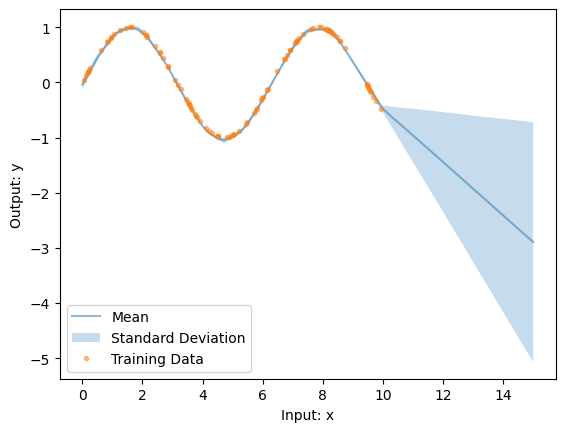

In [6]:
# Test
y_test_hat = emulator.predict(x_test)
y_test_hat_mean = y_test_hat.mean # (1000, 1)
y_test_hat_var = y_test_hat.covariance_matrix # (1000, 1, 1)
y_test_hat_std = torch.sqrt(y_test_hat_var.diagonal(dim1=-2, dim2=-1)) # (1000, 1)
plt.plot(x_test.flatten(), y_test_hat_mean.flatten(), alpha=0.5, label='Mean')
plt.fill_between(
    x_test.flatten(), 
    (y_test_hat_mean - y_test_hat_std).flatten(),
    (y_test_hat_mean + y_test_hat_std).flatten(),
    alpha=0.25,
    label='Standard Deviation'
)
plt.plot(x_train.flatten(), y_train.flatten(), '.', alpha=0.5, label='Training Data')
plt.legend()
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.show()

We can even try making an ensemble of ensembles – any arbitrary combination goes!

In [7]:
# 2 ensembles, each with 4 emulators
emulators = []
for i in range(2):
    subemulators = []
    for j in range(4):
        torch.manual_seed(i + j)
        emulator = MLP(x_train, y_train, layer_dims=[100, 100], lr=1e-2)
        emulator.epochs = 1000
        subemulators.append(emulator)
    emulator = Ensemble(subemulators)
    emulators.append(emulator)

# Train
emulator = Ensemble(emulators)
emulator.fit(x_train, y_train)

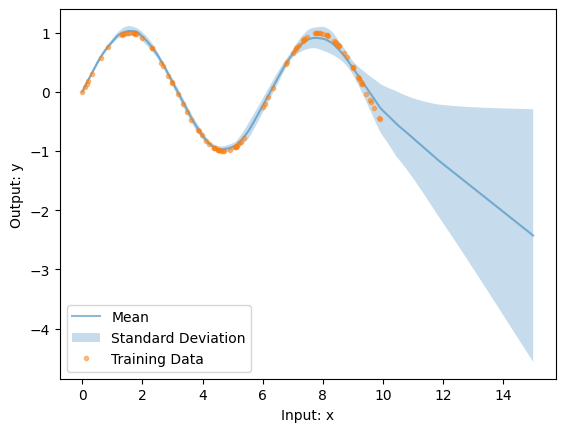

In [44]:
# Test
y_test_hat = emulator.predict(x_test)
y_test_hat_mean = y_test_hat.loc # (1000, 1)
y_test_hat_var = y_test_hat.covariance_matrix # (1000, 1, 1)
y_test_hat_std = torch.sqrt(y_test_hat_var.diagonal(dim1=-2, dim2=-1)) # (1000, 1)
plt.plot(x_test.flatten(), y_test_hat_mean.flatten(), alpha=0.5, label='Mean')
plt.fill_between(
    x_test.flatten(), 
    (y_test_hat_mean - y_test_hat_std).flatten(),
    (y_test_hat_mean + y_test_hat_std).flatten(),
    alpha=0.25,
    label='Standard Deviation'
)
plt.plot(x_train.flatten(), y_train.flatten(), '.', alpha=0.5, label='Training Data')
plt.legend()
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.show()

## Can we do active learning with this?

In active learning, we typically use the emulator's measure of uncertainty as a indication of where we should acquire more data. Lukcily, although the underyling emulators may not provide uncertainty quantification directly, building an ensemble out of them does.

Below we give an example of stream-based active learning, where we are sequentially presented inputs, and we must decide whether or not we want to label them with an output (i.e. add them to the training set). This is important because obtaining an output label may require an expensive run of a simulator. We can drastically reduce the computational cost of building a good emulator – see below. 

In [16]:
from autoemulate.experimental.learners.stream import Adaptive_A_Optimal
from autoemulate.experimental.learners.base import Simulator

In [17]:
class Sin(Simulator):
    def __init__(self, param_ranges={"x": (0., 25.)}, output_names = ["y"]):
        super().__init__(param_ranges, output_names)
    def _forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

In [47]:
emulators = []
for i in range(4):
    torch.manual_seed(i)
    emulator = MLP(x_train, y_train, layer_dims=[100, 100], lr=1e-3, weight_init='xavier_normal')
    emulator.epochs = 20
    emulators.append(emulator)
emulator = Ensemble(emulators)

In [48]:
simulator=Sin()
learner = Adaptive_A_Optimal(
    simulator=simulator, emulator=emulator,
    X_train=x_train, Y_train=y_train,
    threshold=1e-1, Kp=2.0, Ki=1.0, Kd=1.0,
    key="rate", target=0.15,
    min_threshold=0.0,
    max_threshold=0.5,
    window_size=10, show_progress=True
)

In [49]:
x_stream = simulator.sample_inputs(2000, 0)
learner.fit_samples(x_stream)

Adaptive_A_Optimal: 100%|██████████| 2000/2000 [02:11<00:00, 15.22it/s, mse=0.0875, r2=0.823, rate=0.151, logdet=-9.88, trace=5.1e-5, max_eigval=5.1e-5, n_queries=302, score=5.1e-5, threshold=0.423, error_prop=0.00108, error_int=0.0142, error_deriv=-7.56e-5]           


As we see, the MSE asympotitcally approaches zero and then $R^2$ asympotically approaches 1 – all while the active learner tries to maintain a target query rate.

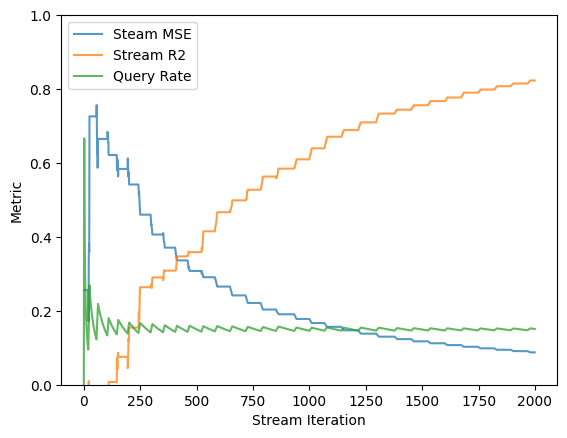

In [50]:
plt.plot(learner.metrics['mse'], alpha=0.75, label='Steam MSE')
plt.plot(learner.metrics['r2'], alpha=0.75, label='Stream R2')
plt.plot(learner.metrics['rate'], alpha=0.75, label='Query Rate')
plt.ylim(0, 1)
plt.xlabel('Stream Iteration')
plt.ylabel('Metric')
plt.legend()
plt.show()

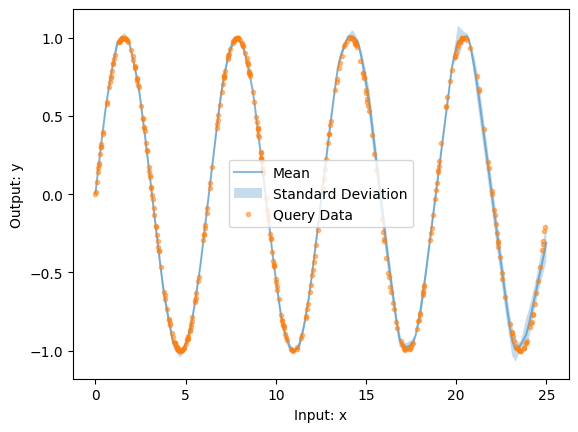

In [51]:
# Test
x_test = torch.linspace(0.0, 25.0, steps=1000).reshape(-1, 1)
y_test_hat = learner.emulator.predict(x_test)
y_test_hat_mean = y_test_hat.loc # (1000, 1)
y_test_hat_var = y_test_hat.covariance_matrix # (1000, 1, 1)
y_test_hat_std = torch.sqrt(y_test_hat_var.diagonal(dim1=-2, dim2=-1)) # (1000, 1)
plt.plot(x_test.flatten(), y_test_hat_mean.flatten(), alpha=0.5, label='Mean')
plt.fill_between(
    x_test.flatten(), 
    (y_test_hat_mean - y_test_hat_std).flatten(),
    (y_test_hat_mean + y_test_hat_std).flatten(),
    alpha=0.25,
    label='Standard Deviation'
)
plt.plot(learner.X_train.flatten(), learner.Y_train.flatten(), '.', alpha=0.5, label='Query Data')
plt.legend()
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.show()

In [52]:
n_stream = x_stream.shape[0]
n_query = learner.X_train.shape[0]
p_query = n_query / n_stream
print(f'We only needed to label {p_query*100:.2f}% of the streaming data!')

We only needed to label 20.10% of the streaming data!


## Dropout Ensembles
Where we get uncertainty quantification by running an NN multiple times with dropout turned on.

In [18]:
from autoemulate.experimental.emulators.ensemble import DropoutEnsemble

In [19]:
emulator = MLP(x_train, y_train, layer_dims=[100, 100], lr=1e-2, dropout_prob=0.2)
emulator.epochs = 1000
emulator = DropoutEnsemble(emulator, n_samples=10)
emulator.fit(x_train, y_train)

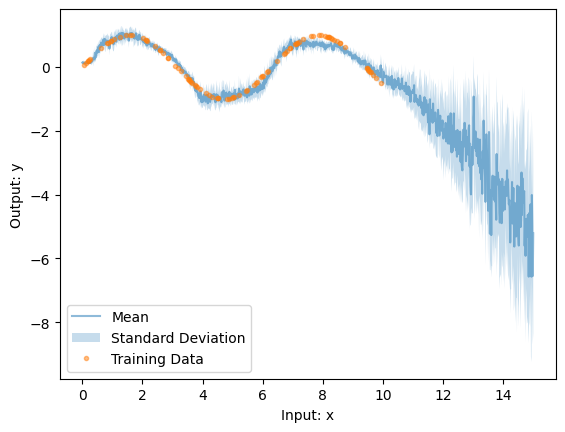

In [20]:
# Test
y_test_hat = emulator.predict(x_test)
y_test_hat_mean = y_test_hat.loc # (1000, 1)
y_test_hat_var = y_test_hat.covariance_matrix # (1000, 1, 1)
y_test_hat_std = torch.sqrt(y_test_hat_var.diagonal(dim1=-2, dim2=-1)) # (1000, 1)
plt.plot(x_test.flatten(), y_test_hat_mean.flatten(), alpha=0.5, label='Mean')
plt.fill_between(
    x_test.flatten(), 
    (y_test_hat_mean - y_test_hat_std).flatten(),
    (y_test_hat_mean + y_test_hat_std).flatten(),
    alpha=0.25,
    label='Standard Deviation'
)
plt.plot(x_train.flatten(), y_train.flatten(), '.', alpha=0.5, label='Training Data')
plt.legend()
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.show()

In [69]:
emulator = MLP(x_train, y_train, layer_dims=[100, 100], lr=1e-3, dropout_prob=0.10)
emulator.epochs = 10
emulator = DropoutEnsemble(emulator, n_samples=20, jitter=1e-7)
simulator=Sin()
learner = Adaptive_A_Optimal(
    simulator=simulator, emulator=emulator,
    X_train=x_train, Y_train=y_train,
    threshold=1e-1, Kp=2.0, Ki=1.0, Kd=1.0,
    key="rate", target=0.25,
    min_threshold=0.0,
    max_threshold=0.5,
    window_size=10, show_progress=True
)

In [70]:
x_stream = simulator.sample_inputs(2000, 0)
learner.fit_samples(x_stream)

Adaptive_A_Optimal: 100%|██████████| 2000/2000 [00:38<00:00, 51.56it/s, mse=0.146, r2=0.716, rate=0.251, logdet=-4.18, trace=0.0153, max_eigval=0.0153, n_queries=502, score=0.0153, threshold=0.345, error_prop=0.00113, error_int=0.0169, error_deriv=-0.000126]          


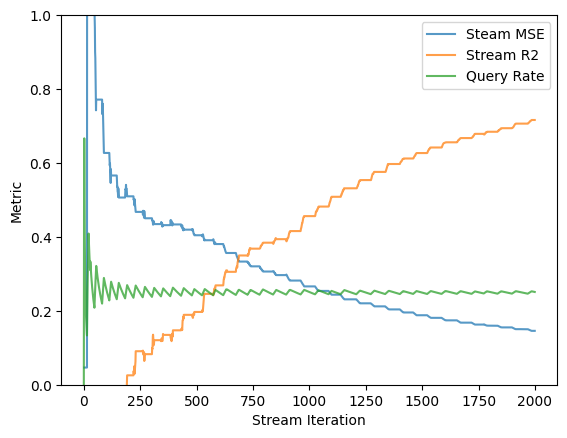

In [71]:
plt.plot(learner.metrics['mse'], alpha=0.75, label='Steam MSE')
plt.plot(learner.metrics['r2'], alpha=0.75, label='Stream R2')
plt.plot(learner.metrics['rate'], alpha=0.75, label='Query Rate')
plt.ylim(0, 1)
plt.xlabel('Stream Iteration')
plt.ylabel('Metric')
plt.legend()
plt.show()

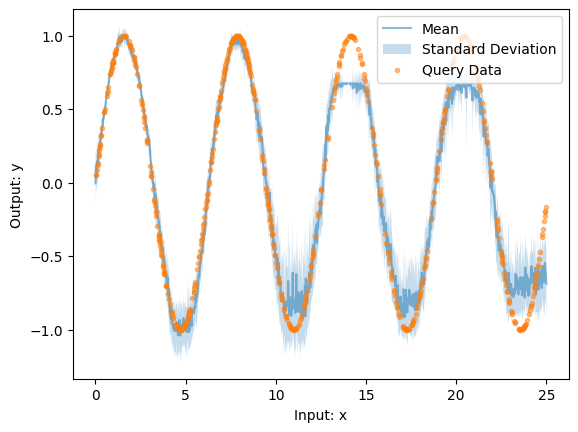

In [72]:
# Test
x_test = torch.linspace(0.0, 25.0, steps=1000).reshape(-1, 1)
y_test_hat = learner.emulator.predict(x_test)
y_test_hat_mean = y_test_hat.loc # (1000, 1)
y_test_hat_var = y_test_hat.covariance_matrix # (1000, 1, 1)
y_test_hat_std = torch.sqrt(y_test_hat_var.diagonal(dim1=-2, dim2=-1)) # (1000, 1)
plt.plot(x_test.flatten(), y_test_hat_mean.flatten(), alpha=0.5, label='Mean')
plt.fill_between(
    x_test.flatten(), 
    (y_test_hat_mean - y_test_hat_std).flatten(),
    (y_test_hat_mean + y_test_hat_std).flatten(),
    alpha=0.25,
    label='Standard Deviation'
)
plt.plot(learner.X_train.flatten(), learner.Y_train.flatten(), '.', alpha=0.5, label='Query Data')
plt.legend()
plt.xlabel('Input: x')
plt.ylabel('Output: y')
plt.show()

In [73]:
n_stream = x_stream.shape[0]
n_query = learner.X_train.shape[0]
p_query = n_query / n_stream
print(f'We only needed to label {p_query*100:.2f}% of the streaming data!')

We only needed to label 30.10% of the streaming data!
